### Set up

There is a uniform current density of $1$ (amps per meter squared) folowing in the copper wires.

If we consider the cylinder to be very long, then the magnetic field will be independent of the coordinate normal to the page. In this case, we have a 2D problem.

> Our goal is to find the magnetic field, $\underline{B}$, everywhere.

### Introduction

We have 2 Maxwell's equations at play. They are Ampere's law, and the no magnetic monopoles law.

Since there are no time dependence in the equation, we do not need to consider the displacement current term in Ampere's law.

Here is Ampere's law (with the displacement current set to 0):
$$
\underline{\nabla} \times \underline{H} = \underline{J}_{f}
$$

Using a linear media approximation, we have the constitutive relation:
$$
\underline{H} = \frac{1}{\mu} \underline{B},
$$
where $\mu = \mu_{0} \mu_{r}$, is the magnetic permeability of the material.

We also draw on definition of the magnetic vector potential:
$$
\underline{\nabla} \times \left(\frac{1}{\mu} \left(\underline{\nabla} \times \underline{A}\right)\right) = \underline{J}_{f}
$$

After some manipulations with vector identities, we have
$$
\underline{\nabla}^{2} \underline{A} = -\mu  \underline{J}_{f}
$$

We know that $\underline{A}$ only has $z$ component, since the volumn current density $J_{f}$ only has $z$ component. This becomes poisson equation for a ``scalar" unknown.

Since we cannot solve the equation for an infinite domain, we trucate the domain, and set $A_{z} = 0$ on th boundary.

We set $J_{f} = 1$ (amperes per area) for the inner set of copper wires, and $J_{f} = -1$ for the outer set of copper wires.


Here is the infinite dimensional weak form
$$
\int_{\Omega} \nabla A_{z} \cdot \nabla v\, dx = \int_{\Omega} \mu J_{z}v\,dx  
$$

In [1]:
from mshr import *
from fenics import *
import numpy as np 

In [2]:
R = 3.0 # radius of the domain, a disk

c_r = 0.1 # radius of copper wires
# distance from the origin where the inner group of wires lie on
wire_radius = 0.5

n = 4 # number of windings

In [5]:
domain = Rectangle(Point(-5,-5),Point(5,5))

# angular coordinate of wire cross-sections
theta = [i*(2*np.pi/n) + np.pi/4.0 for i in range(n)]

wires = [Circle(
    Point(wire_radius*np.cos(t), 
    wire_radius*np.sin(t)), c_r
    ) for t in theta]

In [6]:
# numebering and setting subdomains
wire_numbering = [i for i in range(1, n+1)]

for i, wire in dict(zip(wire_numbering, wires)).items():
    domain.set_subdomain(i, wire)

In [8]:
mesh = generate_mesh(domain, 250)

V = FunctionSpace(mesh, "CG", 2)

def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

In [9]:
# creaste mesh function with unsigned integers corresponding to subdomain numbers
# with dimension 2, equal to the cell dimension
markers = MeshFunction('size_t', mesh, 2, mesh.domains())

# plot(markers, title="Subdomains")

In [10]:
# redefine the integration measure
# we can use dx(0), dx(1),... to integrate over subdomains 0,1,...
dx = Measure('dx', domain = mesh, subdomain_data = markers)

In [11]:
J_in = Constant(1.0)
J_out = Constant(-1.0)

class Permeability(UserExpression): # UserExpression instead of Expression
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs) # This part is new!
        self.markers = markers
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0:
            values[0] = 4*pi*1e-7 # vacuum
        else:
            values[0] = 1.26e-6   # copper

mu = Permeability(markers, degree=1)

In [12]:
A_z = TrialFunction(V)
v = TestFunction(V)

a = dot(grad(A_z), grad(v))*dx
L_in = sum(J_in*v*mu*dx(i) for i in [1,2])
L_out = sum(J_out*v*mu*dx(i) for i in [3,4])
L = L_in+L_out

A_z = Function(V)
solve(a==L, A_z, bc)

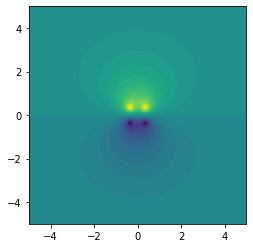

In [13]:
plot(A_z)

In [14]:
W = VectorFunctionSpace(mesh, "CG", 2)
B = project(as_vector((A_z.dx(1), -A_z.dx(0))), W)

In [15]:
file_A_z = File("vector_potential.pvd")
file_A_z << A_z
file_B = File("field.pvd")
file_B << B

In [16]:
X = np.linspace(-5+0.01,5-0.01, 50)
Y = np.linspace(-5+0.01,5-0.01, 50)

Bx = np.zeros((50,50))
By = np.zeros((50,50))

for i in range(len(X)):
    for j in range(len(Y)):
        Bx[i,j] = B(X[i], Y[j])[0]
        By[i,j] = B(X[i], Y[j])[1]

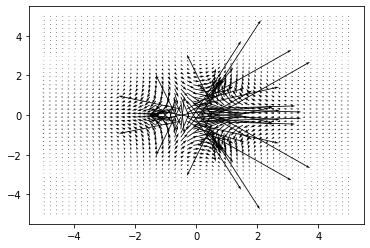

In [17]:
import matplotlib.pyplot as plt 

plt.quiver(X,Y,Bx,By)

In [ ]:
xyz = V.tabulate_dof_coordinates()
x = xyz[:,0]
y = xyz[:,1]

Bx = np.array(B.sub(0).vector())
By = np.array(B.sub(1).vector())